In [ ]:
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
transformers.__version__

'4.37.2'

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
data = pd.read_csv('/content/data_phase3_preprocessed.csv')

In [ ]:
data.head()

,Unnamed: 0,ideal answer,students answer,label
0,0,consequences faced weavers due east india comp...,weavers faced consequences result british east...,partially correct
1,1,ahmad shah abdalis invasion india response naj...,ahmad shah abdalis invasion india response naj...,incorrect
2,2,one example destructive impact colonialism eco...,prime instance destructive impact colonialism ...,correct
3,3,tricolour flags used nationalist movements ind...,tricolour flags used nationalist movements ind...,correct
4,4,french colonies saintdomingue modernday haiti ...,british colonies virginia massachusetts georgi...,incorrect


In [ ]:
data.shape

(8155, 4)

In [ ]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
map = {'partially correct':0,'incorrect':1,'correct':2}

In [ ]:
data['label'] = data['label'].replace(map)

In [ ]:
data.head()

,ideal answer,students answer,label
0,consequences faced weavers due east india comp...,weavers faced consequences result british east...,0
1,ahmad shah abdalis invasion india response naj...,ahmad shah abdalis invasion india response naj...,1
2,one example destructive impact colonialism eco...,prime instance destructive impact colonialism ...,2
3,tricolour flags used nationalist movements ind...,tricolour flags used nationalist movements ind...,2
4,french colonies saintdomingue modernday haiti ...,british colonies virginia massachusetts georgi...,1


In [ ]:
train_size = int(0.9 * len(data))
train_df = data.iloc[:train_size]
val_df = data.iloc[train_size:]

In [ ]:
train_df.shape

(7339, 3)

In [ ]:
val_df.shape

(816, 3)

In [ ]:
train_df.shape

(7339, 3)

In [ ]:
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)#One hot encodding representation
print(f"y_train.shape:{y_train.shape}")

y_val = tf.keras.utils.to_categorical(val_df.label, num_classes=3)
print(f"y_val.shape:{y_val.shape}")

y_train.shape:(7339, 3)
y_val.shape:(816, 3)


In [ ]:
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=32,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets

        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
            truncation=True
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:
max_length = 512

In [ ]:

    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["ideal answer", "students answer"]].values.astype("str"),
    y_train,
    batch_size=8,
    shuffle=True,
)
val_data = BertSemanticDataGenerator(
    val_df[["ideal answer", "students answer"]].values.astype("str"),
    y_val,
    batch_size=32,
    shuffle=False,
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    use_multiprocessing=False,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 27/247 [==>...........................] - ETA: 1:21 - loss: 0.6926 - acc: 0.6713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/247 [===>..........................] - ETA: 1:18 - loss: 0.6756 - acc: 0.6765

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 46/247 [====>.........................] - ETA: 1:14 - loss: 0.6820 - acc: 0.6793

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


138/247 [===============>..............] - ETA: 40s - loss: 0.6746 - acc: 0.6766

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


160/247 [==================>...........] - ETA: 32s - loss: 0.6769 - acc: 0.6820

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


196/247 [======================>.......] - ETA: 19s - loss: 0.6777 - acc: 0.6805

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


223/247 [==========================>...] - ETA: 9s - loss: 0.6671 - acc: 0.6861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 101s 409ms/step - loss: 0.6621 - acc: 0.6857 - val_loss: 0.9736 - val_acc: 0.4948
Epoch 2/10
  9/247 [>.............................] - ETA: 1:29 - loss: 0.6467 - acc: 0.6944

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 59/247 [======>.......................] - ETA: 1:11 - loss: 0.5826 - acc: 0.7733

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 88/247 [=========>....................] - ETA: 1:00 - loss: 0.6046 - acc: 0.7429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


107/247 [===========>..................] - ETA: 53s - loss: 0.6104 - acc: 0.7395

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


146/247 [================>.............] - ETA: 38s - loss: 0.6121 - acc: 0.7277

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/247 [=====================>........] - ETA: 23s - loss: 0.6131 - acc: 0.7272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


226/247 [==========================>...] - ETA: 8s - loss: 0.6194 - acc: 0.7207

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 103s 416ms/step - loss: 0.6261 - acc: 0.7212 - val_loss: 0.9305 - val_acc: 0.5521
Epoch 3/10
 26/247 [==>...........................] - ETA: 1:26 - loss: 0.5421 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 28/247 [==>...........................] - ETA: 1:25 - loss: 0.5356 - acc: 0.7812

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 46/247 [====>.........................] - ETA: 1:18 - loss: 0.5377 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 54/247 [=====>........................] - ETA: 1:15 - loss: 0.5523 - acc: 0.7731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 95/247 [==========>...................] - ETA: 59s - loss: 0.5695 - acc: 0.7605

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


188/247 [=====================>........] - ETA: 23s - loss: 0.5824 - acc: 0.7467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


234/247 [===========================>..] - ETA: 5s - loss: 0.6018 - acc: 0.7324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 104s 423ms/step - loss: 0.6021 - acc: 0.7313 - val_loss: 1.0015 - val_acc: 0.5625
Epoch 4/10
 41/247 [===>..........................] - ETA: 1:20 - loss: 0.5666 - acc: 0.7348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 45/247 [====>.........................] - ETA: 1:19 - loss: 0.5690 - acc: 0.7333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 77/247 [========>.....................] - ETA: 1:06 - loss: 0.5640 - acc: 0.7435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


151/247 [=================>............] - ETA: 37s - loss: 0.5851 - acc: 0.7318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


167/247 [===================>..........] - ETA: 31s - loss: 0.5889 - acc: 0.7335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


205/247 [=======================>......] - ETA: 16s - loss: 0.5776 - acc: 0.7396

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


224/247 [==========================>...] - ETA: 9s - loss: 0.5838 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 424ms/step - loss: 0.5831 - acc: 0.7399 - val_loss: 1.2570 - val_acc: 0.4635
Epoch 5/10
 26/247 [==>...........................] - ETA: 1:26 - loss: 0.5781 - acc: 0.7644

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 69/247 [=======>......................] - ETA: 1:09 - loss: 0.5153 - acc: 0.7736

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 90/247 [=========>....................] - ETA: 1:01 - loss: 0.5309 - acc: 0.7694

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


129/247 [==============>...............] - ETA: 46s - loss: 0.5349 - acc: 0.7713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


184/247 [=====================>........] - ETA: 24s - loss: 0.5285 - acc: 0.7717

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/247 [=====================>........] - ETA: 23s - loss: 0.5289 - acc: 0.7708

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


211/247 [========================>.....] - ETA: 14s - loss: 0.5317 - acc: 0.7684

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 425ms/step - loss: 0.5450 - acc: 0.7601 - val_loss: 1.0538 - val_acc: 0.4635
Epoch 6/10
 39/247 [===>..........................] - ETA: 1:19 - loss: 0.5500 - acc: 0.7244

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 63/247 [======>.......................] - ETA: 1:10 - loss: 0.5031 - acc: 0.7639

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 91/247 [==========>...................] - ETA: 59s - loss: 0.4929 - acc: 0.7734 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


118/247 [=============>................] - ETA: 49s - loss: 0.4971 - acc: 0.7786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/247 [=====================>........] - ETA: 24s - loss: 0.4905 - acc: 0.7787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


200/247 [=======================>......] - ETA: 18s - loss: 0.4896 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


203/247 [=======================>......] - ETA: 16s - loss: 0.4907 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 103s 417ms/step - loss: 0.4946 - acc: 0.7819 - val_loss: 1.0579 - val_acc: 0.5365
Epoch 7/10
 39/247 [===>..........................] - ETA: 1:21 - loss: 0.4718 - acc: 0.8045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 55/247 [=====>........................] - ETA: 1:14 - loss: 0.4668 - acc: 0.8114

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 91/247 [==========>...................] - ETA: 1:01 - loss: 0.4551 - acc: 0.8104

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


145/247 [================>.............] - ETA: 40s - loss: 0.4613 - acc: 0.8103

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


155/247 [=================>............] - ETA: 36s - loss: 0.4579 - acc: 0.8113

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


221/247 [=========================>....] - ETA: 10s - loss: 0.4702 - acc: 0.8049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


228/247 [==========================>...] - ETA: 7s - loss: 0.4693 - acc: 0.8059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 424ms/step - loss: 0.4710 - acc: 0.8026 - val_loss: 1.0583 - val_acc: 0.5312
Epoch 8/10
 33/247 [===>..........................] - ETA: 1:24 - loss: 0.4772 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 46/247 [====>.........................] - ETA: 1:19 - loss: 0.4671 - acc: 0.7935

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 66/247 [=======>......................] - ETA: 1:11 - loss: 0.4300 - acc: 0.8201

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 71/247 [=======>......................] - ETA: 1:09 - loss: 0.4327 - acc: 0.8169

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


102/247 [===========>..................] - ETA: 57s - loss: 0.4384 - acc: 0.8125

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


132/247 [===============>..............] - ETA: 45s - loss: 0.4413 - acc: 0.8163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


217/247 [=========================>....] - ETA: 11s - loss: 0.4435 - acc: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 425ms/step - loss: 0.4505 - acc: 0.8122 - val_loss: 1.1588 - val_acc: 0.4740
Epoch 9/10
 26/247 [==>...........................] - ETA: 1:26 - loss: 0.4248 - acc: 0.8317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/247 [===>..........................] - ETA: 1:23 - loss: 0.4221 - acc: 0.8272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 35/247 [===>..........................] - ETA: 1:22 - loss: 0.4179 - acc: 0.8321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


120/247 [=============>................] - ETA: 49s - loss: 0.4125 - acc: 0.8302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


173/247 [====================>.........] - ETA: 28s - loss: 0.4237 - acc: 0.8266

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/247 [=====================>........] - ETA: 25s - loss: 0.4264 - acc: 0.8245

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


229/247 [==========================>...] - ETA: 7s - loss: 0.4294 - acc: 0.8199

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 424ms/step - loss: 0.4290 - acc: 0.8224 - val_loss: 1.1241 - val_acc: 0.5365
Epoch 10/10
  2/247 [..............................] - ETA: 1:34 - loss: 0.2900 - acc: 0.8750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 17/247 [=>............................] - ETA: 1:29 - loss: 0.3155 - acc: 0.8897

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 18/247 [=>............................] - ETA: 1:29 - loss: 0.3227 - acc: 0.8889

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 96/247 [==========>...................] - ETA: 59s - loss: 0.3833 - acc: 0.8451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


142/247 [================>.............] - ETA: 41s - loss: 0.3948 - acc: 0.8433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


216/247 [=========================>....] - ETA: 12s - loss: 0.3917 - acc: 0.8438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


217/247 [=========================>....] - ETA: 11s - loss: 0.3911 - acc: 0.8439

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/247 [==============================] - 105s 424ms/step - loss: 0.4098 - acc: 0.8315 - val_loss: 1.1624 - val_acc: 0.5104


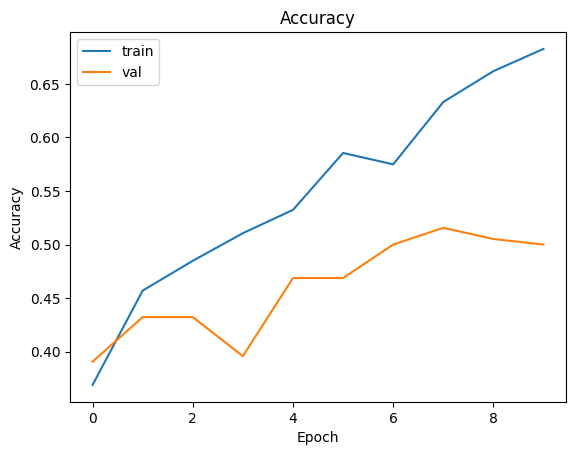

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

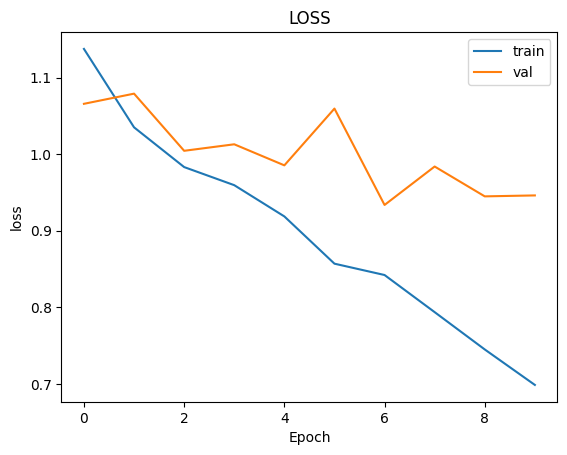

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

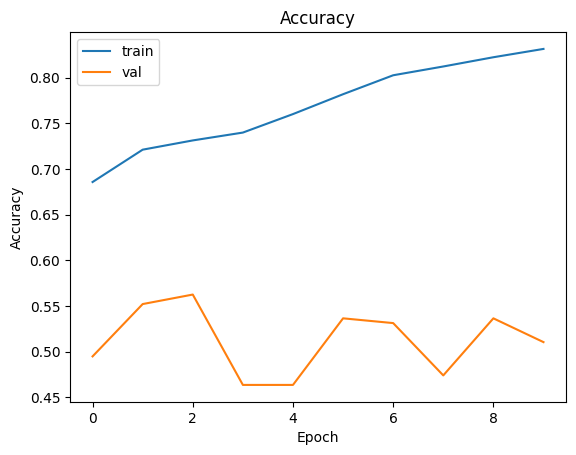

In [ ]:
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

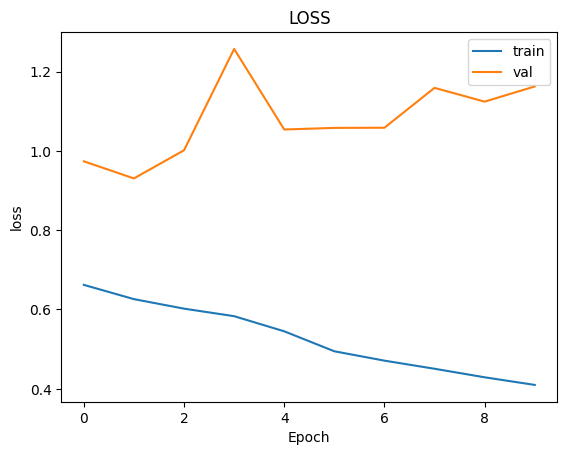

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

# MODEL 2 (best)

In [ ]:

max_length = 512  # Adjust according to your maximum sequence length

# Define input layers
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

# Loading pretrained BERT model
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")

# Connect inputs to the BERT model
bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)

# Bidirectional LSTM with batch normalization and dropout
bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3)
)(bert_output.last_hidden_state)
bi_lstm = tf.keras.layers.BatchNormalization()(bi_lstm)

# Applying hybrid pooling approach to bi_lstm sequence output
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])

# Additional dropout layer
dropout = tf.keras.layers.Dropout(0.5)(concat)

# Dense layer with softmax activation
output = tf.keras.layers.Dense(3, activation="softmax")(dropout)

# Model definition
model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["ideal answer", "students answer"]].values.astype("str"),
    y_train,
    batch_size=32,
    shuffle=True,
)
val_data = BertSemanticDataGenerator(
    val_df[["ideal answer", "students answer"]].values.astype("str"),
    y_val,
    batch_size=32,
    shuffle=False,
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=9,
    use_multiprocessing=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/9


 18/917 [..............................] - ETA: 14:14 - loss: 2.6604 - accuracy: 0.3264

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 85/917 [=>............................] - ETA: 13:48 - loss: 2.4103 - accuracy: 0.3838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


131/917 [===>..........................] - ETA: 13:07 - loss: 2.2545 - accuracy: 0.4151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


201/917 [=====>........................] - ETA: 12:02 - loss: 2.0893 - accuracy: 0.4223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


244/917 [======>.......................] - ETA: 11:19 - loss: 2.0750 - accuracy: 0.4314

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


296/917 [========>.....................] - ETA: 10:28 - loss: 1.9771 - accuracy: 0.4502

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


352/917 [==========>...................] - ETA: 9:31 - loss: 1.8829 - accuracy: 0.4613

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


463/917 [==============>...............] - ETA: 7:39 - loss: 1.7204 - accuracy: 0.4903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


492/917 [===============>..............] - ETA: 7:10 - loss: 1.6894 - accuracy: 0.4954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


617/917 [===================>..........] - ETA: 5:04 - loss: 1.5804 - accuracy: 0.5201

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


876/917 [===========================>..] - ETA: 41s - loss: 1.4125 - accuracy: 0.5609

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


917/917 [==============================] - 1023s 1s/step - loss: 1.3925 - accuracy: 0.5658 - val_loss: 0.6746 - val_accuracy: 0.7487
Epoch 2/9
  6/917 [..............................] - ETA: 15:39 - loss: 1.2088 - accuracy: 0.5000

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/917 [>.............................] - ETA: 14:58 - loss: 1.0385 - accuracy: 0.6544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 48/917 [>.............................] - ETA: 14:43 - loss: 0.9835 - accuracy: 0.6745

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 72/917 [=>............................] - ETA: 14:17 - loss: 0.9346 - accuracy: 0.6771

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


213/917 [=====>........................] - ETA: 11:54 - loss: 0.8738 - accuracy: 0.6837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


300/917 [========>.....................] - ETA: 10:26 - loss: 0.8208 - accuracy: 0.7008

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


338/917 [==========>...................] - ETA: 9:47 - loss: 0.8270 - accuracy: 0.7012

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


572/917 [=================>............] - ETA: 5:50 - loss: 0.8315 - accuracy: 0.6941

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


680/917 [=====================>........] - ETA: 4:00 - loss: 0.8155 - accuracy: 0.7002

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


806/917 [=========================>....] - ETA: 1:52 - loss: 0.7961 - accuracy: 0.7072

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


913/917 [============================>.] - ETA: 4s - loss: 0.7907 - accuracy: 0.7088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


917/917 [==============================] - 965s 1s/step - loss: 0.7915 - accuracy: 0.7092 - val_loss: 0.5177 - val_accuracy: 0.8238
Epoch 3/9
 61/917 [>.............................] - ETA: 14:42 - loss: 0.5477 - accuracy: 0.8053

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 94/917 [==>...........................] - ETA: 14:00 - loss: 0.6648 - accuracy: 0.7646

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


185/917 [=====>........................] - ETA: 12:25 - loss: 0.6722 - accuracy: 0.7561

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


308/917 [=========>....................] - ETA: 10:19 - loss: 0.6773 - accuracy: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


421/917 [============>.................] - ETA: 8:24 - loss: 0.6645 - accuracy: 0.7607

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


455/917 [=============>................] - ETA: 7:49 - loss: 0.6610 - accuracy: 0.7629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


625/917 [===================>..........] - ETA: 4:56 - loss: 0.6676 - accuracy: 0.7616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


639/917 [===================>..........] - ETA: 4:42 - loss: 0.6643 - accuracy: 0.7615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


657/917 [====================>.........] - ETA: 4:24 - loss: 0.6567 - accuracy: 0.7641

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


697/917 [=====================>........] - ETA: 3:43 - loss: 0.6492 - accuracy: 0.7651

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


875/917 [===========================>..] - ETA: 42s - loss: 0.6302 - accuracy: 0.7717

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


917/917 [==============================] - 966s 1s/step - loss: 0.6287 - accuracy: 0.7725 - val_loss: 0.4960 - val_accuracy: 0.7887
Epoch 4/9
 85/917 [=>............................] - ETA: 14:04 - loss: 0.4015 - accuracy: 0.8529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


388/917 [===========>..................] - ETA: 8:57 - loss: 0.4396 - accuracy: 0.8418

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


404/917 [============>.................] - ETA: 8:41 - loss: 0.4366 - accuracy: 0.8425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


469/917 [==============>...............] - ETA: 7:35 - loss: 0.4337 - accuracy: 0.8428

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


514/917 [===============>..............] - ETA: 6:49 - loss: 0.4323 - accuracy: 0.8427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


534/917 [================>.............] - ETA: 6:29 - loss: 0.4339 - accuracy: 0.8422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


574/917 [=================>............] - ETA: 5:48 - loss: 0.4424 - accuracy: 0.8391

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


580/917 [=================>............] - ETA: 5:42 - loss: 0.4422 - accuracy: 0.8388

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


712/917 [======================>.......] - ETA: 3:28 - loss: 0.4428 - accuracy: 0.8383

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


801/917 [=========================>....] - ETA: 1:57 - loss: 0.4453 - accuracy: 0.8355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


907/917 [============================>.] - ETA: 10s - loss: 0.4529 - accuracy: 0.8330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


917/917 [==============================] - 966s 1s/step - loss: 0.4523 - accuracy: 0.8332 - val_loss: 0.5572 - val_accuracy: 0.7850
Epoch 5/9
 19/917 [..............................] - ETA: 15:14 - loss: 0.4552 - accuracy: 0.8158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 30/917 [..............................] - ETA: 15:05 - loss: 0.3693 - accuracy: 0.8542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


122/917 [==>...........................] - ETA: 13:30 - loss: 0.3534 - accuracy: 0.8750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


132/917 [===>..........................] - ETA: 13:20 - loss: 0.3599 - accuracy: 0.8750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


167/917 [====>.........................] - ETA: 12:44 - loss: 0.3704 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


298/917 [========>.....................] - ETA: 10:30 - loss: 0.3456 - accuracy: 0.8754

In [ ]:
plt.plot(history1.history['accuracy'],label='train')
plt.plot(history1.history['val_accuracy'],label='val')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

NameError: name 'plt' is not defined

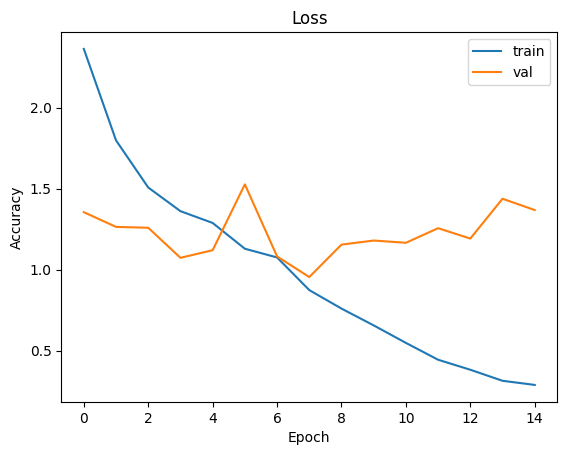

In [ ]:
plt.plot(history1.history['loss'],label='train')
plt.plot(history1.history['val_loss'],label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.save('model3.h5')

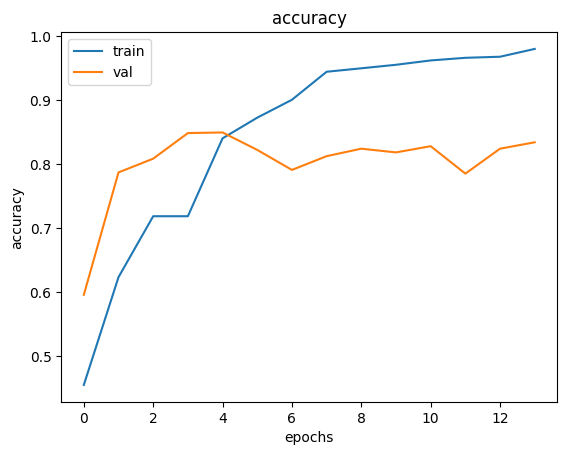

In [ ]:
import matplotlib.pyplot as plt
acc = [0.4548,0.62330,0.7186,0.71860,0.8404,0.8727,0.9007,0.9445,0.9499,0.9554,0.9622,0.96630,0.9680,0.9802]
val_acc = [0.5957,0.7871,0.8086,0.8486,0.8496,0.8223,0.7910,0.8125,0.8242,0.8184,0.8281,0.7852,0.8242,0.8342]
plt.plot(acc,label='train')
plt.plot(val_acc,label='val')
plt.legend()
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime

In [ ]:
!python -m tf2onnx.convert --saved-model lenet_model/ --output lenet_onnx.onnx